Processing file: train.jsonl
File size: 10.53 GB


Processing sessions: 100%|██████████| 12899779/12899779 [10:01:59<00:00, 357.14it/s] 



=== Dataset Summary ===
Total Events: 216,716,096
Unique Sessions: 12,899,779
Unique Products: 1,855,603

=== Event Distribution ===
clicks: 194,720,954 (89.85%)
carts: 16,896,191 (7.80%)
orders: 5,098,951 (2.35%)

=== Time Range ===
Start: 2022-07-31 22:00:00.025000095
End: 2022-08-28 21:59:59.983999968


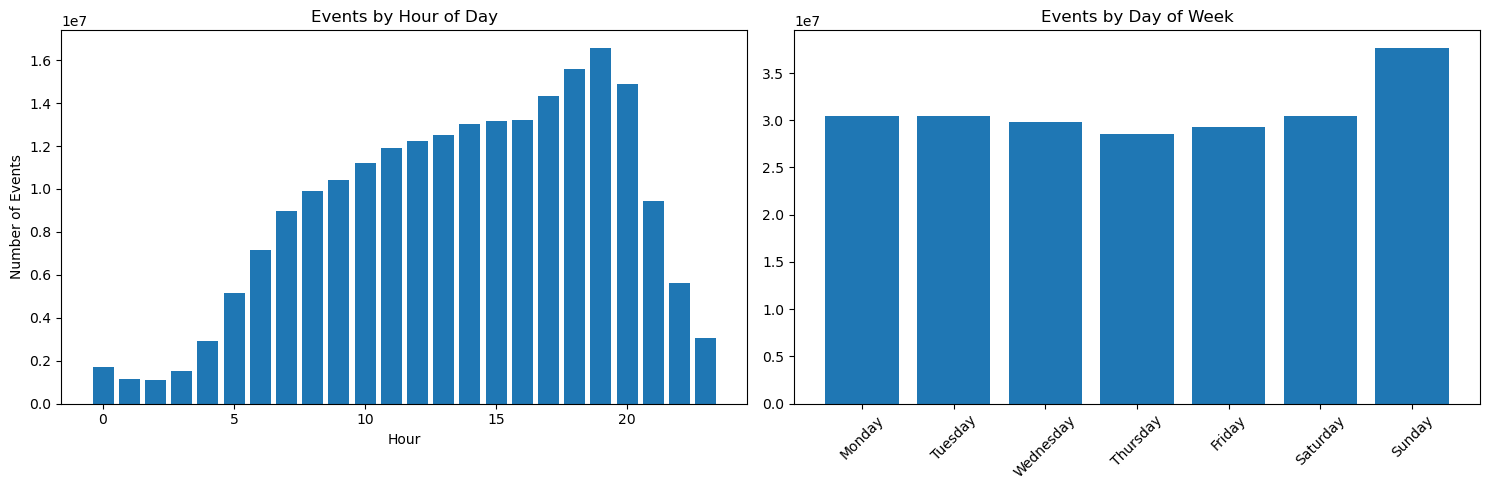

In [5]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import gc
import os
from tqdm import tqdm
import pickle
warnings.filterwarnings('ignore')

class ChunkedDataProcessor:
    def __init__(self, file_path, chunk_size=10000, save_dir='processed_data'):
        self.file_path = file_path
        self.chunk_size = chunk_size
        self.save_dir = save_dir
        self.aggregated_stats = {
            'total_events': 0,
            'unique_sessions': set(),
            'unique_products': set(),
            'event_types': {'clicks': 0, 'carts': 0, 'orders': 0},
            'hourly_distribution': np.zeros(24),
            'daily_distribution': {day: 0 for day in ['Monday', 'Tuesday', 'Wednesday', 
                                                    'Thursday', 'Friday', 'Saturday', 'Sunday']},
            'session_events': {},
            'product_interactions': {},
            'timestamp_min': None,
            'timestamp_max': None
        }
        
        # Create directory for saving intermediate results
        os.makedirs(save_dir, exist_ok=True)

    def safe_timestamp_conversion(self, ts):
        try:
            if ts > 1e11:  # Likely in milliseconds
                ts = ts / 1000
            return pd.to_datetime(ts, unit='s')
        except:
            return None

    def process_chunk(self, chunk):
        events = []
        for session in chunk:
            session_id = session['session']
            for event in session['events']:
                events.append({
                    'session_id': session_id,
                    'aid': event['aid'],
                    'timestamp': event['ts'],
                    'type': event['type']
                })
        return events

    def update_aggregated_stats(self, df):
        # Update basic counts
        self.aggregated_stats['total_events'] += len(df)
        self.aggregated_stats['unique_sessions'].update(df['session_id'].unique())
        self.aggregated_stats['unique_products'].update(df['aid'].unique())
        
        # Update event type counts
        type_counts = df['type'].value_counts()
        for event_type in ['clicks', 'carts', 'orders']:
            self.aggregated_stats['event_types'][event_type] += type_counts.get(event_type, 0)
        
        # Update hourly distribution
        hourly_counts = df['datetime'].dt.hour.value_counts()
        for hour, count in hourly_counts.items():
            self.aggregated_stats['hourly_distribution'][hour] += count
        
        # Update daily distribution
        daily_counts = df['datetime'].dt.day_name().value_counts()
        for day, count in daily_counts.items():
            self.aggregated_stats['daily_distribution'][day] += count
        
        # Update timestamp range
        chunk_min = df['datetime'].min()
        chunk_max = df['datetime'].max()
        if self.aggregated_stats['timestamp_min'] is None or chunk_min < self.aggregated_stats['timestamp_min']:
            self.aggregated_stats['timestamp_min'] = chunk_min
        if self.aggregated_stats['timestamp_max'] is None or chunk_max > self.aggregated_stats['timestamp_max']:
            self.aggregated_stats['timestamp_max'] = chunk_max
        
        # Update session and product statistics
        for session_id, session_df in df.groupby('session_id'):
            if session_id not in self.aggregated_stats['session_events']:
                self.aggregated_stats['session_events'][session_id] = {
                    'clicks': 0, 'carts': 0, 'orders': 0
                }
            for event_type in ['clicks', 'carts', 'orders']:
                self.aggregated_stats['session_events'][session_id][event_type] += \
                    len(session_df[session_df['type'] == event_type])
        
        # Update product interactions
        for aid, product_df in df.groupby('aid'):
            if aid not in self.aggregated_stats['product_interactions']:
                self.aggregated_stats['product_interactions'][aid] = {
                    'clicks': 0, 'carts': 0, 'orders': 0
                }
            for event_type in ['clicks', 'carts', 'orders']:
                self.aggregated_stats['product_interactions'][aid][event_type] += \
                    len(product_df[product_df['type'] == event_type])

    def save_intermediate_results(self, chunk_number):
        filename = f"{self.save_dir}/chunk_{chunk_number}_stats.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(self.aggregated_stats, f)

    def process_full_dataset(self):
        print(f"Processing file: {self.file_path}")
        print(f"File size: {os.path.getsize(self.file_path) / (1024**3):.2f} GB")
        
        chunks_processed = 0
        chunk = []
        
        # Count total lines first
        with open(self.file_path, 'r') as f:
            total_lines = sum(1 for _ in f)
        
        with tqdm(total=total_lines, desc="Processing sessions") as pbar:
            with open(self.file_path, 'r') as f:
                for line in f:
                    try:
                        session = json.loads(line)
                        chunk.append(session)
                        
                        if len(chunk) >= self.chunk_size:
                            # Process chunk
                            events = self.process_chunk(chunk)
                            chunk_df = pd.DataFrame(events)
                            chunk_df['datetime'] = chunk_df['timestamp'].apply(self.safe_timestamp_conversion)
                            
                            # Update statistics
                            self.update_aggregated_stats(chunk_df)
                            
                            # Save intermediate results
                            chunks_processed += 1
                            if chunks_processed % 10 == 0:
                                self.save_intermediate_results(chunks_processed)
                            
                            # Clear memory
                            del events, chunk_df
                            chunk = []
                            gc.collect()
                        
                        pbar.update(1)
                        
                    except Exception as e:
                        print(f"Error processing line: {str(e)}")
                        continue
                
                # Process remaining data
                if chunk:
                    events = self.process_chunk(chunk)
                    chunk_df = pd.DataFrame(events)
                    chunk_df['datetime'] = chunk_df['timestamp'].apply(self.safe_timestamp_conversion)
                    self.update_aggregated_stats(chunk_df)
        
        # Save final results
        self.save_intermediate_results('final')
        return self.aggregated_stats

    def generate_report(self):
        stats = self.aggregated_stats
        
        print("\n=== Dataset Summary ===")
        print(f"Total Events: {stats['total_events']:,}")
        print(f"Unique Sessions: {len(stats['unique_sessions']):,}")
        print(f"Unique Products: {len(stats['unique_products']):,}")
        
        print("\n=== Event Distribution ===")
        for event_type, count in stats['event_types'].items():
            print(f"{event_type}: {count:,} ({count/stats['total_events']*100:.2f}%)")
        
        print("\n=== Time Range ===")
        print(f"Start: {stats['timestamp_min']}")
        print(f"End: {stats['timestamp_max']}")
        
        # Visualizations
        plt.figure(figsize=(15, 5))
        
        # Hourly distribution
        plt.subplot(1, 2, 1)
        plt.bar(range(24), stats['hourly_distribution'])
        plt.title('Events by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Events')
        
        # Daily distribution
        plt.subplot(1, 2, 2)
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plt.bar(days, [stats['daily_distribution'][day] for day in days])
        plt.title('Events by Day of Week')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Usage
processor = ChunkedDataProcessor('train.jsonl', chunk_size=10000)
stats = processor.process_full_dataset()
processor.generate_report()

In [7]:
class DataAnalyzer:
    def __init__(self, stats, output_dir='processed_data'):
        self.stats = stats
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
    def analyze_sessions(self):
        """Step 5: Comprehensive Session Analysis"""
        session_data = {
            'lengths': [],
            'events_per_session': {},
            'conversion_rates': {},
            'session_patterns': defaultdict(int),
            'inter_event_times': []
        }
        
        for session_id, events in self.stats['session_events'].items():
            # Session length
            total_events = sum(events.values())
            session_data['lengths'].append(total_events)
            session_data['events_per_session'][session_id] = events
            
            # Session patterns
            pattern = ''
            if events['clicks'] > 0: pattern += 'C'
            if events['carts'] > 0: pattern += 'A'
            if events['orders'] > 0: pattern += 'O'
            session_data['session_patterns'][pattern] += 1
        
        # Calculate conversion rates
        total_sessions = len(self.stats['unique_sessions'])
        sessions_with_clicks = len([s for s in session_data['events_per_session'].values() 
                                  if s['clicks'] > 0])
        sessions_with_carts = len([s for s in session_data['events_per_session'].values() 
                                 if s['carts'] > 0])
        sessions_with_orders = len([s for s in session_data['events_per_session'].values() 
                                  if s['orders'] > 0])
        
        session_data['conversion_rates'] = {
            'click_to_cart': sessions_with_carts / sessions_with_clicks if sessions_with_clicks > 0 else 0,
            'cart_to_order': sessions_with_orders / sessions_with_carts if sessions_with_carts > 0 else 0,
            'overall_conversion': sessions_with_orders / sessions_with_clicks if sessions_with_clicks > 0 else 0
        }
        
        return session_data
    
    def analyze_products(self):
        """Step 6: Comprehensive Product Analysis"""
        product_data = {
            'popularity': {},
            'conversion_rates': {},
            'sequence_patterns': defaultdict(list),
            'co_occurrences': defaultdict(int)
        }
        
        # Calculate product popularity and conversion rates
        for aid, interactions in self.stats['product_interactions'].items():
            total_interactions = sum(interactions.values())
            product_data['popularity'][aid] = total_interactions
            
            # Product-specific conversion rates
            if interactions['clicks'] > 0:
                product_data['conversion_rates'][aid] = {
                    'cart_rate': interactions['carts'] / interactions['clicks'],
                    'order_rate': interactions['orders'] / interactions['clicks']
                }
        
        return product_data
    
    def generate_visualizations(self, session_data, product_data):
        """Generate comprehensive visualizations"""
        
        # 1. Session Analysis Visualizations
        plt.figure(figsize=(15, 5))
        
        # Session lengths distribution
        plt.subplot(1, 3, 1)
        plt.hist(session_data['lengths'], bins=50)
        plt.title('Distribution of Session Lengths')
        plt.xlabel('Number of Events')
        plt.ylabel('Frequency')
        
        # Session patterns
        plt.subplot(1, 3, 2)
        patterns = list(session_data['session_patterns'].keys())
        counts = list(session_data['session_patterns'].values())
        plt.bar(patterns, counts)
        plt.title('Session Patterns')
        plt.xlabel('Pattern (C=Click, A=Cart, O=Order)')
        plt.ylabel('Count')
        
        # Conversion rates
        plt.subplot(1, 3, 3)
        conv_rates = session_data['conversion_rates']
        plt.bar(conv_rates.keys(), conv_rates.values())
        plt.title('Conversion Rates')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/session_analysis.png")
        plt.close()
        
        # 2. Product Analysis Visualizations
        plt.figure(figsize=(15, 5))
        
        # Product popularity distribution
        plt.subplot(1, 2, 1)
        popularities = list(product_data['popularity'].values())
        plt.hist(popularities, bins=50)
        plt.title('Distribution of Product Popularity')
        plt.xlabel('Number of Interactions')
        plt.ylabel('Frequency')
        
        # Top products
        plt.subplot(1, 2, 2)
        top_products = sorted(product_data['popularity'].items(), 
                            key=lambda x: x[1], reverse=True)[:10]
        plt.bar([str(p[0]) for p in top_products], [p[1] for p in top_products])
        plt.title('Top 10 Products by Interactions')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/product_analysis.png")
        plt.close()
    
    def save_processed_data(self):
        """Save all processed data for Mrunmayee's analysis"""
        
        # Analyze data
        session_data = self.analyze_sessions()
        product_data = self.analyze_products()
        
        # Generate visualizations
        self.generate_visualizations(session_data, product_data)
        
        # Save processed data
        processed_data = {
            'aggregated_stats': self.stats,
            'session_analysis': session_data,
            'product_analysis': product_data
        }
        
        with open(f"{self.output_dir}/processed_data.pkl", 'wb') as f:
            pickle.dump(processed_data, f)
        
        # Generate and save summary report
        self.generate_summary_report(session_data, product_data)
    
    def generate_summary_report(self, session_data, product_data):
        """Generate comprehensive summary report"""
        
        report = []
        
        # Basic Statistics Summary
        report.append("=== Basic Dataset Statistics ===")
        report.append(f"Total Events: {self.stats['total_events']:,}")
        report.append(f"Unique Sessions: {len(self.stats['unique_sessions']):,}")
        report.append(f"Unique Products: {len(self.stats['unique_products']):,}")
        
        # Event Distribution
        report.append("\n=== Event Distribution ===")
        for event_type, count in self.stats['event_types'].items():
            report.append(f"{event_type}: {count:,} ({count/self.stats['total_events']*100:.2f}%)")
        
        # Session Analysis
        report.append("\n=== Session Analysis ===")
        report.append(f"Average Session Length: {np.mean(session_data['lengths']):.2f} events")
        report.append(f"Median Session Length: {np.median(session_data['lengths']):.2f} events")
        report.append("\nConversion Rates:")
        for rate_type, rate in session_data['conversion_rates'].items():
            report.append(f"{rate_type}: {rate*100:.2f}%")
        
        # Product Analysis
        report.append("\n=== Product Analysis ===")
        report.append("Top 10 Products by Interactions:")
        top_products = sorted(product_data['popularity'].items(), 
                            key=lambda x: x[1], reverse=True)[:10]
        for aid, count in top_products:
            report.append(f"Product {aid}: {count:,} interactions")
        
        # Save report
        with open(f"{self.output_dir}/analysis_report.txt", 'w') as f:
            f.write('\n'.join(report))


analyzer = DataAnalyzer(stats)
analyzer.save_processed_data()

print("\nAnalysis complete! Data saved in 'processed_data' directory.")
print("Files generated:")
print("1. processed_data.pkl - Complete processed dataset")
print("2. session_analysis.png - Session analysis visualizations")
print("3. product_analysis.png - Product analysis visualizations")
print("4. analysis_report.txt - Comprehensive summary report")


Analysis complete! Data saved in 'processed_data' directory.
Files generated:
1. processed_data.pkl - Complete processed dataset
2. session_analysis.png - Session analysis visualizations
3. product_analysis.png - Product analysis visualizations
4. analysis_report.txt - Comprehensive summary report
